In [1]:
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
from sklearn.decomposition import TruncatedSVD

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Loading data and exploring

In [6]:
airport = pd.read_csv("search_sample_data/airports.csv")

In [7]:
airport.head()

,location_id,location_type,airport_group,country_code,country,region,latitude,longitude
0,airport/0,airport,airport/0,BR,Brazil,South America,-29.153099,-53.743301
1,airport/AAA,airport,airport/AAA,FR,French Polynesia,Oceania,-17.352600,-145.509995
2,airport/AAB,airport,airport/AAB,AU,Australia,Oceania,-26.700001,141.050003
3,airport/AAC,airport,airport/AAC,EG,Egypt,Africa and Mideast,31.073299,33.835800
4,airport/AAE,airport,airport/AAE,DZ,Algeria,Africa and Mideast,36.822201,7.809170


In [8]:
airport['location_type'].unique()

array(['airport', 'city'], dtype=object)

In [9]:
watch_sample_full = pd.read_csv("search_sample_data/watch_sample.csv")

In [10]:
watch_sample_full.shape

(1168145, 40)

In [11]:
watch_sample = watch_sample_full

In [12]:
watch_sample.shape

(1168145, 40)

In [13]:
watch_sample.columns

Index(['user_id', 'trip_id', 'trip_type', 'origin', 'destination',
       'origin_type', 'destination_type', 'departure_date', 'return_date',
       'stay', 'weekend', 'filter_no_lcc', 'filter_non_stop',
       'filter_short_layover', 'filter_name', 'first_searched_dt',
       'watch_added_dt', 'status_latest', 'latest_status_change_dt',
       'status_updates', 'total_notifs', 'total_buy_notifs', 'first_rec',
       'first_price', 'first_buy_dt', 'first_buy_price', 'lowest_price',
       'last_notif_dt', 'forecast_first_target_price',
       'forecast_first_good_price', 'forecast_last_target_price',
       'forecast_last_good_price', 'forecast_last_warning_date',
       'forecast_last_danger_date', 'forecast_min_target_price',
       'forecast_max_target_price', 'forecast_min_good_price',
       'forecast_max_good_price', 'first_advance', 'watch_advance'],
      dtype='object')

In [14]:
len(watch_sample['user_id'].unique()), watch_sample.shape[0]/len(watch_sample['user_id'].unique())

(75000, 15.575266666666666)

In [15]:
len(watch_sample['trip_id'].unique())

1116410

In [16]:
np.sum(watch_sample['trip_id'].value_counts() > 1)

40711

In [17]:
watch_sample['trip_type'].unique()

array(['one_way', 'round_trip'], dtype=object)

In [18]:
len(watch_sample['origin'].unique()), len(watch_sample['destination'].unique())

(1341, 1630)

In [19]:
watch_sample['origin_type'].unique(), watch_sample['destination_type'].unique()

(array(['airport', 'city'], dtype=object),
 array(['airport', 'city'], dtype=object))

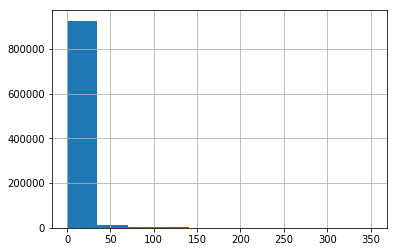

In [24]:
watch_sample['stay'].hist()

In [20]:
watch_sample.dtypes

user_id                         object
trip_id                         object
trip_type                       object
origin                          object
destination                     object
origin_type                     object
destination_type                object
departure_date                  object
return_date                     object
stay                           float64
weekend                          int64
filter_no_lcc                    int64
filter_non_stop                  int64
filter_short_layover             int64
filter_name                     object
first_searched_dt               object
watch_added_dt                  object
status_latest                   object
latest_status_change_dt         object
status_updates                   int64
total_notifs                   float64
total_buy_notifs               float64
first_rec                       object
first_price                    float64
first_buy_dt                    object
first_buy_price          

In [21]:
pd.set_option('display.max_columns', 50)
watch_sample.head(1)

,user_id,trip_id,trip_type,origin,destination,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,first_searched_dt,watch_added_dt,status_latest,latest_status_change_dt,status_updates,total_notifs,total_buy_notifs,first_rec,first_price,first_buy_dt,first_buy_price,lowest_price,last_notif_dt,forecast_first_target_price,forecast_first_good_price,forecast_last_target_price,forecast_last_good_price,forecast_last_warning_date,forecast_last_danger_date,forecast_min_target_price,forecast_max_target_price,forecast_min_good_price,forecast_max_good_price,first_advance,watch_advance
0,945e05e2b2510be2edb1149348fdb24852f2a6fe101e6c...,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/BCN,airport/EWR,airport,airport,2018-03-01,NaN,NaN,0,0,0,0,NoFilter,2018-02-26 01:22:51,2018-02-26 01:22:59,expired,2018-03-02 03:00:00,3,1.0,1.0,buy,464.0,2018-02-26 01:22:51,464.0,464.0,2018-02-28 10:58:16,406.0,248.0,491.0,245.0,2017-12-02,2018-01-18,406.0,491.0,245.0,248.0,3,3.0


In [24]:
#watch_sample['stay'].unique()

In [25]:
date_cols =['departure_date',
'return_date',
'first_searched_dt',
'watch_added_dt',
'latest_status_change_dt',
'first_buy_dt',
'last_notif_dt',
'forecast_last_warning_date',
'forecast_last_danger_date']



In [26]:
for col in date_cols:
    #print(col)
    watch_sample[col] = pd.to_datetime(watch_sample[col])

In [ ]:
watch_sample = watch_sample.loc[:50000,:]

# Method 1: Find same column across Trip id and define similarity

In [27]:
df_trip = watch_sample.groupby('trip_id').agg('nunique')

In [28]:
df_trip.shape

(49873, 40)

In [29]:
np.sum(df_trip >1)

user_id                        126
trip_id                          0
trip_type                        0
origin                           0
destination                      0
origin_type                      0
destination_type                 0
departure_date                   0
return_date                      0
stay                             0
weekend                          0
filter_no_lcc                    0
filter_non_stop                  0
filter_short_layover             0
filter_name                      0
first_searched_dt              126
watch_added_dt                  16
status_latest                   62
latest_status_change_dt        124
status_updates                  61
total_notifs                    58
total_buy_notifs                54
first_rec                       44
first_price                    107
first_buy_dt                    40
first_buy_price                 29
lowest_price                   111
last_notif_dt                    6
forecast_first_targe

validating one way/ two way trip with return date

In [30]:
watch_sample[(watch_sample['trip_type']=='one_way') & ~pd.isnull(watch_sample['return_date'])]

,user_id,trip_id,trip_type,origin,destination,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,first_searched_dt,watch_added_dt,status_latest,latest_status_change_dt,status_updates,total_notifs,total_buy_notifs,first_rec,first_price,first_buy_dt,first_buy_price,lowest_price,last_notif_dt,forecast_first_target_price,forecast_first_good_price,forecast_last_target_price,forecast_last_good_price,forecast_last_warning_date,forecast_last_danger_date,forecast_min_target_price,forecast_max_target_price,forecast_min_good_price,forecast_max_good_price,first_advance,watch_advance


In [31]:
watch_sample[(watch_sample['trip_type']!='one_way') & pd.isnull(watch_sample['return_date'])]

,user_id,trip_id,trip_type,origin,destination,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,first_searched_dt,watch_added_dt,status_latest,latest_status_change_dt,status_updates,total_notifs,total_buy_notifs,first_rec,first_price,first_buy_dt,first_buy_price,lowest_price,last_notif_dt,forecast_first_target_price,forecast_first_good_price,forecast_last_target_price,forecast_last_good_price,forecast_last_warning_date,forecast_last_danger_date,forecast_min_target_price,forecast_max_target_price,forecast_min_good_price,forecast_max_good_price,first_advance,watch_advance


In [32]:
watch_sample[(watch_sample['trip_type']=='one_way') & ~pd.isnull(watch_sample['stay'])]

,user_id,trip_id,trip_type,origin,destination,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,first_searched_dt,watch_added_dt,status_latest,latest_status_change_dt,status_updates,total_notifs,total_buy_notifs,first_rec,first_price,first_buy_dt,first_buy_price,lowest_price,last_notif_dt,forecast_first_target_price,forecast_first_good_price,forecast_last_target_price,forecast_last_good_price,forecast_last_warning_date,forecast_last_danger_date,forecast_min_target_price,forecast_max_target_price,forecast_min_good_price,forecast_max_good_price,first_advance,watch_advance


In [33]:
watch_sample[(watch_sample['trip_type']!='one_way') & pd.isnull(watch_sample['stay'])]

,user_id,trip_id,trip_type,origin,destination,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,first_searched_dt,watch_added_dt,status_latest,latest_status_change_dt,status_updates,total_notifs,total_buy_notifs,first_rec,first_price,first_buy_dt,first_buy_price,lowest_price,last_notif_dt,forecast_first_target_price,forecast_first_good_price,forecast_last_target_price,forecast_last_good_price,forecast_last_warning_date,forecast_last_danger_date,forecast_min_target_price,forecast_max_target_price,forecast_min_good_price,forecast_max_good_price,first_advance,watch_advance


In [34]:
trip_features = ['trip_id','trip_type','origin','destination','origin_type','destination_type','departure_date','return_date','stay','weekend',
'filter_no_lcc','filter_non_stop','filter_short_layover','filter_name']

In [35]:
trip_data = watch_sample[trip_features].drop_duplicates()

In [36]:
trip_data.shape

(49873, 14)

In [37]:
trip_data['filter_name'].unique()

array(['NoFilter', 'And(NonStop,NoLCC)', 'ShortLayover', 'NonStop',
       'NoLCC', 'And(ShortLayover,NoLCC)'], dtype=object)

# Putting coodinates for origin/destination

In [38]:
trip_data_origin = trip_data.merge(airport[['location_id','latitude','longitude']], left_on='origin', right_on='location_id')

In [39]:
trip_data_origin.rename(columns = {'latitude':'latitude_origin'}, inplace = True) 
trip_data_origin.rename(columns = {'longitude':'longitude_origin'}, inplace = True) 

In [40]:
trip_data_destination =  trip_data_origin.merge(airport[['location_id','latitude','longitude']], left_on='destination', right_on='location_id')

In [41]:
trip_data_destination.rename(columns = {'latitude':'latitude_destination'}, inplace = True) 
trip_data_destination.rename(columns = {'longitude':'longitude_destination'}, inplace = True) 

In [42]:
trip_data_destination.head()

,trip_id,trip_type,origin,destination,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,location_id_x,latitude_origin,longitude_origin,location_id_y,latitude_destination,longitude_destination
0,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport/BCN,airport/EWR,airport,airport,2018-03-01,NaT,NaN,0,0,0,0,NoFilter,airport/BCN,41.297100,2.07846,airport/EWR,40.692501,-74.168701
1,f5552c10-5465-30a2-a34a-66b9fc06bc24,round_trip,airport/BCN,airport/EWR,airport,airport,2019-07-28,2019-08-10,13.0,0,0,1,0,NonStop,airport/BCN,41.297100,2.07846,airport/EWR,40.692501,-74.168701
2,99341aa4-341a-372c-8d0d-78b7a64728c9,one_way,airport/BCN,airport/EWR,airport,airport,2018-02-28,NaT,NaN,0,0,0,0,NoFilter,airport/BCN,41.297100,2.07846,airport/EWR,40.692501,-74.168701
3,d72776c7-015e-3b16-9400-56eff2594194,round_trip,city/QHO,airport/EWR,city,airport,2019-01-08,2019-01-13,5.0,0,1,0,0,NoLCC,city/QHO,29.814899,-95.31015,airport/EWR,40.692501,-74.168701
4,cab24962-174d-352d-be46-d9500a3b0127,round_trip,city/QHO,airport/EWR,city,airport,2018-04-09,2018-04-20,11.0,0,0,0,0,NoFilter,city/QHO,29.814899,-95.31015,airport/EWR,40.692501,-74.168701


In [43]:
trip_data_destination.drop(['origin','destination','location_id_x','location_id_y'], axis=1, inplace=True)

In [44]:
trip_data_destination.columns

Index(['trip_id', 'trip_type', 'origin_type', 'destination_type',
       'departure_date', 'return_date', 'stay', 'weekend', 'filter_no_lcc',
       'filter_non_stop', 'filter_short_layover', 'filter_name',
       'latitude_origin', 'longitude_origin', 'latitude_destination',
       'longitude_destination'],
      dtype='object')

In [45]:
trip_data_destination['trip_type'].value_counts()

round_trip    40503
one_way        9370
Name: trip_type, dtype: int64

In [46]:
#trip_data_destination['departure_month'] = trip_data_destination['departure_date'].apply(lambda x: x.strftime('%B'))

 Converting date into month and year

In [47]:
trip_data_destination['departure_month'] = pd.DatetimeIndex(trip_data_destination['departure_date']).month

In [48]:
trip_data_destination['departure_year'] = pd.DatetimeIndex(trip_data_destination['departure_date']).year

In [49]:
dummies = pd.get_dummies(trip_data_destination[['origin_type','destination_type','filter_name']])

In [50]:
trip_data_dummies = pd.concat([trip_data_destination,dummies], axis=1)

In [51]:
trip_data_dummies.head()

,trip_id,trip_type,origin_type,destination_type,departure_date,return_date,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,filter_name,latitude_origin,longitude_origin,latitude_destination,longitude_destination,departure_month,departure_year,origin_type_airport,origin_type_city,destination_type_airport,destination_type_city,"filter_name_And(NonStop,NoLCC)","filter_name_And(ShortLayover,NoLCC)",filter_name_NoFilter,filter_name_NoLCC,filter_name_NonStop,filter_name_ShortLayover
0,ddc5e806-226f-335d-a9f9-e59c55550832,one_way,airport,airport,2018-03-01,NaT,NaN,0,0,0,0,NoFilter,41.297100,2.07846,40.692501,-74.168701,3,2018,1,0,1,0,0,0,1,0,0,0
1,f5552c10-5465-30a2-a34a-66b9fc06bc24,round_trip,airport,airport,2019-07-28,2019-08-10,13.0,0,0,1,0,NonStop,41.297100,2.07846,40.692501,-74.168701,7,2019,1,0,1,0,0,0,0,0,1,0
2,99341aa4-341a-372c-8d0d-78b7a64728c9,one_way,airport,airport,2018-02-28,NaT,NaN,0,0,0,0,NoFilter,41.297100,2.07846,40.692501,-74.168701,2,2018,1,0,1,0,0,0,1,0,0,0
3,d72776c7-015e-3b16-9400-56eff2594194,round_trip,city,airport,2019-01-08,2019-01-13,5.0,0,1,0,0,NoLCC,29.814899,-95.31015,40.692501,-74.168701,1,2019,0,1,1,0,0,0,0,1,0,0
4,cab24962-174d-352d-be46-d9500a3b0127,round_trip,city,airport,2018-04-09,2018-04-20,11.0,0,0,0,0,NoFilter,29.814899,-95.31015,40.692501,-74.168701,4,2018,0,1,1,0,0,0,1,0,0,0


# Building recommendation for one way trip users

In [52]:
trip_data_one_way = trip_data_dummies[trip_data_dummies['trip_type']=='one_way']

In [53]:
trip_data_one_way.drop(['trip_type','departure_date','origin_type','destination_type','return_date','stay','filter_name'], axis=1, inplace=True)

In [54]:
trip_data_one_way.columns

Index(['trip_id', 'weekend', 'filter_no_lcc', 'filter_non_stop',
       'filter_short_layover', 'latitude_origin', 'longitude_origin',
       'latitude_destination', 'longitude_destination', 'departure_month',
       'departure_year', 'origin_type_airport', 'origin_type_city',
       'destination_type_airport', 'destination_type_city',
       'filter_name_And(NonStop,NoLCC)', 'filter_name_And(ShortLayover,NoLCC)',
       'filter_name_NoFilter', 'filter_name_NoLCC', 'filter_name_NonStop',
       'filter_name_ShortLayover'],
      dtype='object')

In [55]:
trip_data_one_way_indexed= trip_data_one_way.set_index('trip_id')

In [56]:
trip_data_one_way_indexed.values.shape

(9370, 20)

In [57]:
To_scale_cols = ['latitude_origin','longitude_origin','latitude_destination','longitude_destination','departure_month','departure_year']

In [58]:
scaler = MinMaxScaler()

In [59]:
trip_data_one_way_indexed[To_scale_cols] = scaler.fit_transform(trip_data_one_way_indexed[To_scale_cols])

In [62]:
matrix_one_way = trip_data_one_way_indexed.values

In [63]:
matrix_one_way.shape

(9370, 20)

# Applying SVD to reduce dimension

In [66]:
svd_trip = TruncatedSVD(n_components=8, n_iter=7, random_state=42)
matrix_one_way_reduced = svd_trip.fit_transform(matrix_one_way)


In [67]:
svd_trip.explained_variance_ratio_.sum()

0.9379961332240733

In [68]:
matrix_one_way_reduced

array([[ 2.02274332, -0.46248829, -0.03273532, ..., -0.03262604,
         0.05816198, -0.11872103],
       [ 2.00031867, -0.46961999, -0.03391888, ..., -0.03641018,
         0.05431601, -0.13839912],
       [ 1.46078099,  0.31756809,  1.0007268 , ..., -0.21234706,
         0.01556548,  0.01110001],
       ...,
       [ 1.9838212 , -0.47516694, -0.03041432, ..., -0.07481698,
         0.01976828,  0.04652459],
       [ 1.28857975, -0.65843018, -0.08529541, ..., -0.16328326,
         1.28771494, -0.15540268],
       [ 1.48221792, -0.61722777, -0.08169033, ..., -0.20211453,
         0.62052618, -0.08718952]])

In [105]:
#A = np.matrix.round(matrix_one_way_reduced,2)

Cosine Similarity between all one way trips

In [70]:
dist = cosine_similarity(matrix_one_way_reduced,matrix_one_way_reduced)

In [71]:
dist.shape

(9370, 9370)

In [72]:
dist_df = pd.DataFrame(dist, columns =trip_data_one_way_indexed.index )

In [73]:
dist_df.index = trip_data_one_way_indexed.index

In [74]:
trip_ids = list(trip_data_one_way_indexed.index)

In [77]:
from heapq import nsmallest

def second_smallest(numbers):
    return nsmallest(2, numbers)[-1]

In [78]:
def min_trip(y):
    x = list(y)
    num = second_smallest(x)
    ind = x.index(num)
    return trip_ids[ind]


In [79]:
dist_df['minimum_dis_trip'] = dist_df.apply(min_trip)

In [80]:
dist_df['minimum_dis_trip'].head()

trip_id
ddc5e806-226f-335d-a9f9-e59c55550832    f725f130-ee4d-3eca-8bb9-a79f0b58800a
99341aa4-341a-372c-8d0d-78b7a64728c9    f725f130-ee4d-3eca-8bb9-a79f0b58800a
2bd02cc2-c2ed-3e20-8e5b-4de41043a6c3    01687df6-4c4e-3909-8c04-784563b2a450
01aa02ef-9787-3c5b-9118-ca6859fe9fd2    c73dc659-96c2-3a8b-ac0f-fab621809dea
e39df009-d84d-3b8a-800e-73966fc1ac23    f725f130-ee4d-3eca-8bb9-a79f0b58800a
Name: minimum_dis_trip, dtype: object

In [82]:
dist_df.reset_index(inplace=True)

In [83]:
watch_sample_one_way = watch_sample[watch_sample['trip_type']=='one_way']

In [84]:
watch_sample_one_way.shape, len(watch_sample_one_way['user_id'].unique())

((9387, 40), 6062)

In [86]:
one_way_recommendations = watch_sample_one_way.merge(dist_df[['trip_id','minimum_dis_trip']], on='trip_id')[['user_id','trip_id','minimum_dis_trip']]

In [87]:
one_way_recommendations.shape, watch_sample_one_way.shape

((9387, 3), (9387, 40))

In [88]:
one_way_user_trips = one_way_recommendations.groupby('user_id')['trip_id'].apply(list)                                                        

In [89]:
one_way_user_trips.loc['00191968c472deb3a857df8b83a29953a48d029c6f64151f87a035fe58ae7161']

['a151809e-45e4-3f0e-a280-36f685b1cdd3',
 '2fdbca5c-3f85-3e30-869a-0ad520a0a3f5']

In [90]:
one_way_user_recommed = one_way_recommendations.groupby('user_id')['minimum_dis_trip'].apply(list)   

Finding Total Final recommendations

In [91]:
one_way_final = pd.DataFrame({'trips':one_way_user_trips, 'recommed':one_way_user_recommed})

In [92]:
pd.set_option('display.max_columns', 50)
one_way_final['trips'].head(1)

user_id
00191968c472deb3a857df8b83a29953a48d029c6f64151f87a035fe58ae7161    [a151809e-45e4-3f0e-a280-36f685b1cdd3, 2fdbca5...
Name: trips, dtype: object

# Filtering trips with which are already used

In [94]:
def filtered_reco(row):
    ls_trip = (row['trips'])
    ls_reco = (row['recommed'])
    A =set(ls_reco)
    B = set(ls_trip)
    to_recommend =(A-B )
    return to_recommend
    

In [95]:
one_way_final['final_recommend'] = one_way_final.apply(filtered_reco,axis=1)

In [96]:
np.sum(one_way_final['recommed'] !=one_way_final['final_recommend'])

6062

In [97]:
one_way_final['trips'][0], one_way_final['final_recommend'][0]

(['a151809e-45e4-3f0e-a280-36f685b1cdd3',
  '2fdbca5c-3f85-3e30-869a-0ad520a0a3f5'],
 {'1dd0cc4f-611b-31e2-a2be-8e063b9a95eb',
  'e6dd968c-4430-3cea-b3bf-bb065d1ab7a0'})

In [ ]:
# Will recommend trips which are close to origin, destination, and close to departure and arrival date. 

In [99]:
one_way_final.head()

,trips,recommed,final_recommend
user_id,,,
00191968c472deb3a857df8b83a29953a48d029c6f64151f87a035fe58ae7161,"[a151809e-45e4-3f0e-a280-36f685b1cdd3, 2fdbca5...","[1dd0cc4f-611b-31e2-a2be-8e063b9a95eb, e6dd968...","{e6dd968c-4430-3cea-b3bf-bb065d1ab7a0, 1dd0cc4..."
001a25f124e240f5372e8c73117c54bd1b1ae6339bf864100a9abd1ddafa49ff,"[ac3b556c-62de-382f-8aea-d04f7dd26d20, 1e64796...","[13e84dc9-0ef1-31da-be2d-7b62c395352c, fb60bea...","{13e84dc9-0ef1-31da-be2d-7b62c395352c, b42b62c..."
001a3a530d9471da8f5cb4ea972a6cd266bb9c2b057a7d31b350738d7853ea66,[47335ba7-eaf8-3e12-8330-2654677f4b62],[5919937a-8a1f-3316-beb8-d853106ee093],{5919937a-8a1f-3316-beb8-d853106ee093}
002027e0af745a7978420fdec4439969aa191cd1390aaf50fb8f36610990d8b0,[0a707a01-202d-300d-a41d-1929bf6520c4],[f3a3111d-ba11-3c60-bcbd-9b96df4fe94c],{f3a3111d-ba11-3c60-bcbd-9b96df4fe94c}
0020fa3f50b5cedf7904ee6da92fbb2b90d6a536115243cd2af359effe3993ec,"[d489723b-f807-3010-b00c-c4067395cc8a, be8ae69...","[5919937a-8a1f-3316-beb8-d853106ee093, 5919937...",{5919937a-8a1f-3316-beb8-d853106ee093}


In [100]:
one_way_final.to_csv('one_way_trip_recommendations.csv')

# Working on return trips

In [143]:
trip_data_two_way_ = trip_data_dummies[trip_data_dummies['trip_type']=='round_trip']
trip_data_two_way= trip_data_two_way_.set_index('trip_id')
trip_data_two_way.drop(['origin_type','destination_type','filter_name'], axis=1, inplace=True)

In [144]:
trip_data_two_way['return_month'] = pd.DatetimeIndex(trip_data_two_way['return_date']).month
trip_data_two_way['return_year'] = pd.DatetimeIndex(trip_data_two_way['return_date']).year

In [145]:
two_way_trips = list(trip_data_two_way_['trip_id'])

In [146]:
trip_data_two_way.drop(['trip_type','return_date','departure_date'], axis=1, inplace=True)

In [149]:
To_scale_cols_return = ['stay','latitude_origin','longitude_origin','latitude_destination','longitude_destination','departure_month','departure_year']

In [150]:
scaler = MinMaxScaler()

In [151]:
trip_data_two_way[To_scale_cols_return] = scaler.fit_transform(trip_data_two_way[To_scale_cols_return])

In [152]:
matrix_two_way = trip_data_two_way.values

In [159]:
svd_trip_round = TruncatedSVD(n_components=3, n_iter=7, random_state=42)
matrix_two_way_reduced = svd_trip_round.fit_transform(matrix_two_way)

In [160]:
svd_trip_round.explained_variance_ratio_.sum()

0.9071336987697468

In [161]:
matrix_two_way_reduced.shape

(40503, 3)

In [171]:
matrix_two_way_reduced = np.matrix.round(matrix_two_way_reduced, 2)

In [174]:
matrix_two_way_reduced = matrix_two_way_reduced.astype('float32')

In [175]:
gc.collect()

315

In [176]:
dist_twoway = cosine_similarity(matrix_two_way_reduced, matrix_two_way_reduced)

In [177]:
trip_data_two_way.head()

,stay,weekend,filter_no_lcc,filter_non_stop,filter_short_layover,latitude_origin,longitude_origin,latitude_destination,longitude_destination,departure_month,departure_year,origin_type_airport,origin_type_city,destination_type_airport,destination_type_city,"filter_name_And(NonStop,NoLCC)","filter_name_And(ShortLayover,NoLCC)",filter_name_NoFilter,filter_name_NoLCC,filter_name_NonStop,filter_name_ShortLayover,return_month,return_year
trip_id,,,,,,,,,,,,,,,,,,,,,,,
f5552c10-5465-30a2-a34a-66b9fc06bc24,0.040000,0,0,1,0,0.782853,0.479294,0.767192,0.285962,0.545455,0.5,1,0,1,0,0,0,0,0,1,0,8,2019
d72776c7-015e-3b16-9400-56eff2594194,0.015385,0,1,0,0,0.676835,0.190120,0.767192,0.285962,0.000000,0.5,0,1,1,0,0,0,0,1,0,0,1,2019
cab24962-174d-352d-be46-d9500a3b0127,0.033846,0,0,0,0,0.676835,0.190120,0.767192,0.285962,0.272727,0.0,0,1,1,0,0,0,1,0,0,0,4,2018
2c37e24c-6efd-370f-b017-2a87f7ac3f03,0.021538,0,0,0,0,0.676835,0.190120,0.767192,0.285962,0.363636,0.5,0,1,1,0,0,0,1,0,0,0,5,2019
d9daed47-a7c5-39c7-9f62-63f0c43c39e4,0.012308,1,0,0,0,0.748892,0.109756,0.767192,0.285962,0.545455,0.0,1,0,1,0,0,0,1,0,0,0,7,2018


In [178]:
dist_df_return = pd.DataFrame(dist_twoway, columns =trip_data_two_way.index )

In [179]:
dist_df_return.head()

trip_id,f5552c10-5465-30a2-a34a-66b9fc06bc24,d72776c7-015e-3b16-9400-56eff2594194,cab24962-174d-352d-be46-d9500a3b0127,2c37e24c-6efd-370f-b017-2a87f7ac3f03,d9daed47-a7c5-39c7-9f62-63f0c43c39e4,d47f8d55-f694-34d2-9c07-6b663b76d956,407df1b6-498b-3da8-a7b0-c2c3911444ff,e2743c48-6c40-3c5d-b0b8-c1c7c3bce450,0441fe56-cb5e-3b7b-9ea1-29228335e871,d3e874d4-98f9-33d4-bbe9-d48c4744dd4a,867fe62b-b2e8-3b8c-952b-e99a78ea8a3c,55c466bc-f902-3dda-b982-9c0f4388c3ad,e3b19096-44c4-3972-8851-0b5c5f47d840,f0d574c8-47d1-38f5-be3a-80fc97d2650d,a309bf59-4796-3382-8a98-26532b5b862f,f61bab9e-f014-311d-bc2e-18fbfa677663,8fc0c8e2-7c57-36b1-bff6-363d8523f78a,38680493-a3fb-383c-8474-d5fa581ecad7,6c560333-eaa6-37ff-a554-fc0debb02508,421c7a0d-e749-33ed-9193-7e280a4e80d8,1b4112fc-1689-377a-81f5-af38b66a57d5,ea259069-7fc1-3c5a-8545-1f527297636d,c2b1333d-767c-33d8-9034-b0bf90ecc020,ef7f8a29-4217-3fb0-899f-b31e0e324b27,5eeda2bd-4434-3abc-818c-15c6662846b8,...,10b536e7-9e86-39e3-bfaa-8ea68dcb7dc0,95622df2-1798-3da4-b3a9-7de1e678048c,2dada3a8-710b-32be-a079-3badbea646a7,d34a86cb-2eee-374f-8a6b-ff464b0caa6b,5e8c8aeb-5c22-385b-9dc1-832d9daf6ba2,c110c839-7658-3319-92b3-bb8f985d7fce,e5e572e0-f1ea-3c99-9e67-e4201f767dc5,e0877e6f-a9b2-3684-aba1-e83436c2c39a,c784ca0d-5ee6-3a73-9581-38fd62adde94,e462cca9-fa34-3c78-95bf-e585fe4171f9,704eb0d2-eadc-309e-ada1-ba6d80273127,a7304bfa-14eb-3be4-b516-448bf361f0c6,cee5e662-2df5-3d4f-8749-d4d2fae380d8,70fd3b0c-60f6-3968-95eb-9f1e7ac4ab81,de5ff00e-15f4-30ad-8e7a-ef5b2471e09f,08241424-6f78-30f5-af0b-b24e6c145a52,e0d64355-e06f-3f20-a3ce-8b09655655fc,3ca91b06-2995-30f1-92eb-c9b79b476e1c,6620d578-fd4f-32f7-b703-bd992836d31c,d964fa6e-f3ac-3345-a3c1-a48b12c00dff,d2d57590-fd31-3593-a6fb-5f0306eec4e7,f4f4dfc5-a903-3e0e-a37d-777b5508dc1c,e61a0754-4167-3895-9148-9d0570407cc7,be89e30c-ec6e-3114-ab5a-01b393a41487,5744b7b0-0abc-3524-a29a-87013c1e38b7
0,1.000000,0.999994,0.999998,0.999999,1.000000,0.999999,1.000000,1.000000,1.000000,0.999999,1.000000,0.999999,0.999999,0.999998,0.999994,0.999998,0.999999,0.999999,1.000000,0.999998,1.000000,0.999996,0.999999,0.999999,0.999997,...,1.000000,0.999999,1.000000,1.000000,0.999999,0.999998,1.000000,0.999999,1.000000,1.000000,0.999994,1.000000,0.999994,0.999998,1.000000,1.000000,0.999997,0.999997,0.999999,0.999999,0.999996,0.999999,0.999996,0.999998,0.999999
1,0.999994,1.000000,0.999999,0.999998,0.999995,0.999998,0.999997,0.999995,0.999995,0.999987,0.999995,0.999998,0.999990,0.999985,1.000000,0.999999,0.999987,0.999990,0.999992,0.999999,0.999992,1.000000,0.999987,0.999998,0.999999,...,0.999992,0.999998,0.999995,0.999997,0.999990,0.999999,0.999997,0.999990,0.999997,0.999994,1.000000,0.999990,1.000000,0.999985,0.999994,0.999997,0.999999,0.999999,0.999998,0.999998,1.000000,0.999998,1.000000,0.999985,0.999998
2,0.999998,0.999999,1.000000,1.000000,0.999999,1.000000,0.999999,0.999999,0.999999,0.999994,0.999999,1.000000,0.999995,0.999992,0.999999,1.000000,0.999994,0.999995,0.999997,1.000000,0.999997,0.999999,0.999994,1.000000,1.000000,...,0.999997,1.000000,0.999999,0.999999,0.999995,1.000000,0.999999,0.999996,0.999999,0.999998,0.999999,0.999995,0.999999,0.999992,0.999998,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,0.999999,0.999992,1.000000
3,0.999999,0.999998,1.000000,1.000000,0.999999,1.000000,1.000000,0.999999,0.999999,0.999995,0.999999,1.000000,0.999997,0.999994,0.999998,1.000000,0.999995,0.999997,0.999998,1.000000,0.999998,0.999999,0.999995,1.000000,0.999999,...,0.999998,1.000000,0.999999,1.000000,0.999997,1.000000,1.000000,0.999997,1.000000,0.999999,0.999998,0.999997,0.999998,0.999994,0.999999,1.000000,0.999999,0.999999,1.000000,1.000000,0.999999,1.000000,0.999999,0.999994,1.000000
4,1.000000,0.999995,0.999999,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,0.999998,1.000000,1.000000,0.999999,0.999997,0.999996,0.999999,0.999998,0.999999,1.000000,0.999999,1.000000,0.999997,0.999998,1.000000,0.999998,...,0.999999,1.000000,1.000000,1.000000,0.999999,0.999999,1.000000,0.999999,1.000000,1.

In [180]:
dist_df_return.index = trip_data_two_way.index 

In [181]:
trip_ids = list(trip_data_two_way.index)

In [182]:
dist_df_return['minimum_dis_trip'] = dist_df_return.apply(min_trip,axis=1)

In [183]:
dist_df_return.head()

trip_id,f5552c10-5465-30a2-a34a-66b9fc06bc24,d72776c7-015e-3b16-9400-56eff2594194,cab24962-174d-352d-be46-d9500a3b0127,2c37e24c-6efd-370f-b017-2a87f7ac3f03,d9daed47-a7c5-39c7-9f62-63f0c43c39e4,d47f8d55-f694-34d2-9c07-6b663b76d956,407df1b6-498b-3da8-a7b0-c2c3911444ff,e2743c48-6c40-3c5d-b0b8-c1c7c3bce450,0441fe56-cb5e-3b7b-9ea1-29228335e871,d3e874d4-98f9-33d4-bbe9-d48c4744dd4a,867fe62b-b2e8-3b8c-952b-e99a78ea8a3c,55c466bc-f902-3dda-b982-9c0f4388c3ad,e3b19096-44c4-3972-8851-0b5c5f47d840,f0d574c8-47d1-38f5-be3a-80fc97d2650d,a309bf59-4796-3382-8a98-26532b5b862f,f61bab9e-f014-311d-bc2e-18fbfa677663,8fc0c8e2-7c57-36b1-bff6-363d8523f78a,38680493-a3fb-383c-8474-d5fa581ecad7,6c560333-eaa6-37ff-a554-fc0debb02508,421c7a0d-e749-33ed-9193-7e280a4e80d8,1b4112fc-1689-377a-81f5-af38b66a57d5,ea259069-7fc1-3c5a-8545-1f527297636d,c2b1333d-767c-33d8-9034-b0bf90ecc020,ef7f8a29-4217-3fb0-899f-b31e0e324b27,5eeda2bd-4434-3abc-818c-15c6662846b8,...,95622df2-1798-3da4-b3a9-7de1e678048c,2dada3a8-710b-32be-a079-3badbea646a7,d34a86cb-2eee-374f-8a6b-ff464b0caa6b,5e8c8aeb-5c22-385b-9dc1-832d9daf6ba2,c110c839-7658-3319-92b3-bb8f985d7fce,e5e572e0-f1ea-3c99-9e67-e4201f767dc5,e0877e6f-a9b2-3684-aba1-e83436c2c39a,c784ca0d-5ee6-3a73-9581-38fd62adde94,e462cca9-fa34-3c78-95bf-e585fe4171f9,704eb0d2-eadc-309e-ada1-ba6d80273127,a7304bfa-14eb-3be4-b516-448bf361f0c6,cee5e662-2df5-3d4f-8749-d4d2fae380d8,70fd3b0c-60f6-3968-95eb-9f1e7ac4ab81,de5ff00e-15f4-30ad-8e7a-ef5b2471e09f,08241424-6f78-30f5-af0b-b24e6c145a52,e0d64355-e06f-3f20-a3ce-8b09655655fc,3ca91b06-2995-30f1-92eb-c9b79b476e1c,6620d578-fd4f-32f7-b703-bd992836d31c,d964fa6e-f3ac-3345-a3c1-a48b12c00dff,d2d57590-fd31-3593-a6fb-5f0306eec4e7,f4f4dfc5-a903-3e0e-a37d-777b5508dc1c,e61a0754-4167-3895-9148-9d0570407cc7,be89e30c-ec6e-3114-ab5a-01b393a41487,5744b7b0-0abc-3524-a29a-87013c1e38b7,minimum_dis_trip
trip_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f5552c10-5465-30a2-a34a-66b9fc06bc24,1.000000,0.999994,0.999998,0.999999,1.000000,0.999999,1.000000,1.000000,1.000000,0.999999,1.000000,0.999999,0.999999,0.999998,0.999994,0.999998,0.999999,0.999999,1.000000,0.999998,1.000000,0.999996,0.999999,0.999999,0.999997,...,0.999999,1.000000,1.000000,0.999999,0.999998,1.000000,0.999999,1.000000,1.000000,0.999994,1.000000,0.999994,0.999998,1.000000,1.000000,0.999997,0.999997,0.999999,0.999999,0.999996,0.999999,0.999996,0.999998,0.999999,d60f5a5d-9465-3f06-b8ff-76c443411c39
d72776c7-015e-3b16-9400-56eff2594194,0.999994,1.000000,0.999999,0.999998,0.999995,0.999998,0.999997,0.999995,0.999995,0.999987,0.999995,0.999998,0.999990,0.999985,1.000000,0.999999,0.999987,0.999990,0.999992,0.999999,0.999992,1.000000,0.999987,0.999998,0.999999,...,0.999998,0.999995,0.999997,0.999990,0.999999,0.999997,0.999990,0.999997,0.999994,1.000000,0.999990,1.000000,0.999985,0.999994,0.999997,0.999999,0.999999,0.999998,0.999998,1.000000,0.999998,1.000000,0.999985,0.999998,d1f96be3-7c5e-30cd-9140-7dc5b3e85f6e
cab24962-174d-352d-be46-d9500a3b0127,0.999998,0.999999,1.000000,1.000000,0.999999,1.000000,0.999999,0.999999,0.999999,0.999994,0.999999,1.000000,0.999995,0.999992,0.999999,1.000000,0.999994,0.999995,0.999997,1.000000,0.999997,0.999999,0.999994,1.000000,1.000000,...,1.000000,0.999999,0.999999,0.999995,1.000000,0.999999,0.999996,0.999999,0.999998,0.999999,0.999995,0.999999,0.999992,0.999998,0.999999,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,0.999999,0.999992,1.000000,d1f96be3-7c5e-30cd-9140-7dc5b3e85f6e
2c37e24c-6efd-370f-b017-2a87f7ac3f03,0.999999,0.999998,1.000000,1.000000,0.999999,1.000000,1.000000,0.999999,0.999999,0.999995,0.999999,1.000000,0.999997,0.999994,0.999998,1.000000,0.999995,0.999997,0.999998,1.000000,0.999998,0.999999,0.999995,1.000000,0.999999,...,1.000000,0.999999,1.000000,0.999997,1.000000,1.000000,0.999997,1.000000,0.999999,0.999998,0.999997,0.999998,0.999994,0.999999,1.000000,0.999999,0.999999,1.000000,1.000000,0.999999,1.000000,0.999999,0.999994,1.000000,d1f96be3-7c5e-30cd-9140-7dc5b3e85f6e
d9daed47-a7c5-39c7-9f62

In [184]:
dist_df_return.reset_index(inplace=True)
watch_sample_two_way = watch_sample[watch_sample['trip_type']=='round_trip']
two_way_recommendations = watch_sample_two_way.merge(dist_df_return[['trip_id','minimum_dis_trip']], on='trip_id')[['user_id','trip_id','minimum_dis_trip']]
two_way_user_trips = two_way_recommendations.groupby('user_id')['trip_id'].apply(list)    
two_way_user_recommed = two_way_recommendations.groupby('user_id')['minimum_dis_trip'].apply(list)
two_way_final= pd.DataFrame({'trips':two_way_user_trips , 'recommed':two_way_user_recommed})

two_way_final['final_recommend'] = two_way_final.apply(filtered_reco,axis=1)

In [185]:
two_way_final.head()

,trips,recommed,final_recommend
user_id,,,
000bbcaf465120bf100f9375b01710100c7782386f5ff94f86549312ab6423e3,[c581ace7-40d3-3b3e-adc9-69d8a7e8059c],[d865199b-7405-3e09-86f9-6fb6bf88e1d3],{d865199b-7405-3e09-86f9-6fb6bf88e1d3}
000e715d0f69d265f7f9384e232b035c3d5608e6175ec365b307516e0bb562f1,"[6c2123c2-d546-3f23-95c4-ee99ca1d82e4, f6dc6ef...","[d865199b-7405-3e09-86f9-6fb6bf88e1d3, a8f119a...","{a8f119ae-80de-3f0e-bd44-5f64d05ea3b4, d865199..."
000f29ccbefd711c6d273f2a543f7979d37e863ee24b90032e437b1810a89b17,[653ce5f6-8eda-3e74-a443-550c453f4980],[a8f119ae-80de-3f0e-bd44-5f64d05ea3b4],{a8f119ae-80de-3f0e-bd44-5f64d05ea3b4}
0010305bb6bd33ec306637109e50046a28711fe2e8f2a9f38f53282cb832cf4d,"[2a01fc76-7b40-3a0c-b5ac-267c5fc834dc, df5aeeb...","[a8f119ae-80de-3f0e-bd44-5f64d05ea3b4, d60f5a5...","{a8f119ae-80de-3f0e-bd44-5f64d05ea3b4, d60f5a5..."
00104926657606e1e12ee878c2f37aa90d1858f97c32e6f758c54e249f4f2f55,[a9253bc6-e1ae-319a-a95a-34337631d6ff],[d865199b-7405-3e09-86f9-6fb6bf88e1d3],{d865199b-7405-3e09-86f9-6fb6bf88e1d3}


In [186]:
two_way_final.to_csv('Two_way_trip_recommendations.csv')